<a href="https://www.kaggle.com/code/wanps1/notebook56490a2613?scriptVersionId=224184064" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🔥 제4강 머신러닝을 활용한 신용평가 모델 개발</p>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-data/train_df_sample.pkl
/kaggle/input/4-amex/__results__.html
/kaggle/input/4-amex/__notebook__.ipynb
/kaggle/input/4-amex/__output__.json
/kaggle/input/4-amex/custom.css
/kaggle/input/4-amex/__results___files/__results___63_0.png
/kaggle/input/4-amex/__results___files/__results___64_0.png
/kaggle/input/4-amex/__results___files/__results___44_0.png
/kaggle/input/4-amex/__results___files/__results___42_0.png


> ### 위 코드는 kaggle 노트북에서 제공되는 코드로, 데이터 파일의 경로를 보여줍니다.

In [2]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

> #### 주피터 노트북 스타일을 변경해주었습니다.

In [3]:
import warnings
warnings.filterwarnings('ignore', module='sklearn.metrics.cluster')
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

> #### Pickle 파일을 읽어옵니다. 위에서 프린트된 경로를 입력해주어야 합니다.

In [4]:
df = pd.read_pickle('/kaggle/input/train-data/train_df_sample.pkl')

> #### Index를 설정해주고, head() 를 통해 데이터를 살펴봅니다.

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🧱 Feature Engineering</p>

In [5]:
df = df.reset_index()

In [6]:
df.head()

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
0,f9e9fbdc82859e7fdcea35523a78f466aa40d1bb7158da...,0.419922,0.033698,0.390381,0.449951,0.390869,0.336670,0.383050,0.000727,0.680176,...,1,U,1,1,1.0,1,1,5.0,1,1
1,824526e632f8f6c497b71cb13ec0a519be76344d472970...,0.603516,0.033983,0.542480,0.651367,0.613281,0.284424,0.238159,0.004951,0.801758,...,13,U,1,0,NaN,0,13,6.0,1,0
2,b73f63bcbb43055d5bc1b0c4365efa407a939455387a25...,0.823730,NaN,0.823730,0.823730,0.823730,0.000104,NaN,0.000104,0.000104,...,0,NaN,0,0,NaN,0,0,NaN,0,0
3,783d9b5d9f6594d1a5a42d8474d328b72e8f2a5adc0a60...,0.925293,0.070185,0.702637,0.964844,0.957031,0.136353,0.149279,0.000043,0.389404,...,13,O,1,13,1.0,1,13,6.0,1,0
4,2f6a347c73f2fd188d6e110f04275bacb5e0550d7d9d6c...,0.864258,0.017011,0.826172,0.890625,0.826172,0.105286,0.137151,0.004486,0.324707,...,13,R,1,0,NaN,0,13,6.0,1,0


> #### 이 데이터는 Amex prediction default 데이터를 한 명의 고객 단위로 피벗(pivot)하고 10만 개를 샘플링한 데이터입니다. 

> #### Hash된 ID값이 보입니다. 이렇게 긴 문자열은 데이터 사이즈가 클 경우 메모리 사용량에 영향을 주게 됩니다. 필요한 만큼만 인코딩해서 사용하도록 합니다. 이번 노트북에서 ID 열이 별도로 필요하진 않지만, Hash된 값을 인코딩하는 방법을 함수로 구현해 적용해보겠습니다.

In [7]:
import hashlib

def encode_customer_id(id_str):
    encoded_id = hashlib.sha256(id_str.encode('utf-8')).hexdigest()[:16]
    return encoded_id

df['customer_ID'] = df['customer_ID'].apply(encode_customer_id)

In [8]:
def drop_null_cols(df, threshold=0.8):
    """
    데이터프레임에서 결측치 비율이 threshold 이상인 변수를 제거하는 함수
    """
    null_percent = df.isnull().mean()
    drop_cols = list(null_percent[null_percent >= threshold].index)
    df = df.drop(drop_cols, axis=1)
    print(f"Dropped {len(drop_cols)} columns: {', '.join(drop_cols)}")
    return df

> #### 먼저 결측치 비율이 높은 변수를 제거해보겠습니다. 우리는 먼저 결측치에 대한 탐색작업이 끝났다고 가정합니다. 즉, 해당 데이터의 결측치에는 특별한 의미가 없다고 가정합니다. 하지만 실제 모델링 과정에서 해당 결측치가 발생한 원인을 파악하는 것은 매우 중요한 작업입니다. 

> #### 결측치 제거를 위해 별도 함수를 만들어도 되고, 나중에 변수 선택 (feature selection) 부분에서 추가하거나 오픈소스 라이브러리를 사용해도 됩니다. 

> #### 코드를 간결하게 하기 위해 함수(function)화 하는 작업은 매우 중요합니다. 

In [9]:
df = drop_null_cols(df)

Dropped 106 columns: D_49_mean, D_49_std, D_49_min, D_49_max, D_49_last, D_73_mean, D_73_std, D_73_min, D_73_max, D_73_last, D_76_mean, D_76_std, D_76_min, D_76_max, D_76_last, R_9_mean, R_9_std, R_9_min, R_9_max, R_9_last, B_29_mean, B_29_std, B_29_min, B_29_max, B_29_last, D_87_mean, D_87_std, D_87_min, D_87_max, D_87_last, D_88_mean, D_88_std, D_88_min, D_88_max, D_88_last, D_106_mean, D_106_std, D_106_min, D_106_max, D_106_last, R_26_mean, R_26_std, R_26_min, R_26_max, R_26_last, D_108_mean, D_108_std, D_108_min, D_108_max, D_108_last, D_110_mean, D_110_std, D_110_min, D_110_max, D_110_last, D_111_mean, D_111_std, D_111_min, D_111_max, D_111_last, B_39_mean, B_39_std, B_39_min, B_39_max, B_39_last, B_42_mean, B_42_std, B_42_min, B_42_max, B_42_last, D_132_mean, D_132_std, D_132_min, D_132_max, D_132_last, D_134_mean, D_134_std, D_134_min, D_134_max, D_134_last, D_135_mean, D_135_std, D_135_min, D_135_max, D_135_last, D_136_mean, D_136_std, D_136_min, D_136_max, D_136_last, D_137_me

In [10]:
cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_68"
]
cat_features = [f"{cf}_last" for cf in cat_features]

> #### 범주형(categorical) 변수에 대한 정보는 원천 데이터(raw data) 설명에 나와있습니다. 

In [11]:
import random

num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if 'target' not in col and col not in cat_features]
num_cols_sample = random.sample([col for col in num_cols if 'target' not in col], 100)

> #### 우리는 범주형 변수와 100개의 수치형 변수를 임의로 선택하도록 하겠습니다. (Kaggle에서 제공하는 노트북 성능의 한계로 인해 너무 많은 변수는 다루기 어렵습니다)

In [12]:
feature_list = num_cols_sample + cat_features
all_list = feature_list + ['target']

In [13]:
df = df[all_list]

In [14]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

> #### 위 요약 테이블은 데이터 정보를 한 눈에 볼 수 있도록 해줍니다. 직접 함수를 구현하지 않고, 오픈소스 라이브러리를 사용해도 됩니다. 

In [15]:
summary(df)

data shape: (100000, 111)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
R_28_max,float16,0,0.000,1885,0.000024,1.009766,0.008446,0.00927,0.005318
B_37_last,float16,0,0.000,12081,-1.347656,1.328125,0.047516,0.018341,0.174683
B_13_mean,float16,308,0.308,9194,0.000012,63.65625,0.035217,2.335938,NaN
R_7_min,float16,0,0.000,8217,0.0,40.25,0.001148,0.001942,0.005264
D_52_std,float64,1373,1.373,95923,0.0,0.710495,0.003025,0.002379,NaN
...,...,...,...,...,...,...,...,...,...
D_126_last,float16,0,0.000,2,0.0,1.0,1.0,1.0,0.0
D_63_last,category,0,0.000,6,NaN,NaN,CO,CL,CO
D_64_last,category,1144,1.144,4,NaN,NaN,U,U,NaN
D_68_last,float16,1151,1.151,7,0.0,6.0,5.0,6.0,NaN


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* 신속한 EDA 기능을 구현한 오픈 소스 라이브러리는 많습니다.
    
* pandas-profiling 은 데이터프레임의 요약 통계 정보를 자동으로 생성해주는 라이브러리입니다. 데이터셋의 기본 통계, 상관 관계, 미싱 데이터, 변수 분포 등을 확인할 수 있습니다.
    
* missingno는 결측 데이터를 시각화하여 데이터셋의 누락된 값을 쉽게 파악할 수 있는 도구입니다. 

In [16]:
import gc
gc.collect()

0

gc.collect()는 파이썬의 가비지 컬렉터(Garbage Collector)를 명시적으로 호출하여 메모리를 회수하는 역할을 합니다. 가비지 컬렉터는 더 이상 사용되지 않는 객체들을 자동으로 메모리에서 해제하는 파이썬의 기능입니다.

gc.collect()를 호출하는 이유는 다음과 같습니다:

메모리 관리: 파이썬은 동적 메모리 할당 및 해제를 처리하기 때문에, 메모리 관리가 중요합니다. gc.collect()를 사용하여 더 이상 필요하지 않은 객체들을 메모리에서 제거함으로써 메모리 사용량을 최적화할 수 있습니다.

메모리 누수 방지: 가비지 컬렉터는 메모리 누수를 방지하기 위해 사용될 수 있습니다. 메모리 누수란 더 이상 사용되지 않는 객체들이 메모리에 남아있어 메모리 사용량이 계속해서 증가하는 현상을 말합니다. gc.collect()를 호출하여 메모리에서 제거되지 않은 객체들을 강제로 회수함으로써 메모리 누수를 방지할 수 있습니다.

성능 개선: 가비지 컬렉터는 메모리 회수에 관여하므로, 불필요한 객체들을 빠르게 회수함으로써 프로그램의 전반적인 성능을 향상시킬 수 있습니다.

gc.collect()는 일반적으로 명시적으로 호출할 필요가 없으며, 파이썬 인터프리터가 자동으로 가비지 컬렉션을 수행합니다. 하지만 특정 시점에서 메모리를 즉시 회수하고자 할 때 사용될 수 있습니다. 주로 대규모 데이터 처리나 장기간 실행되는 프로그램에서 메모리 사용을 최적화하기 위해 사용됩니다.

In [17]:
df[cat_features].head()

,B_30_last,B_38_last,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_68_last
0,0.0,5.0,0.0,0.0,-1.0,1.0,1.0,CO,U,5.0
1,0.0,3.0,0.0,0.0,4.0,0.0,1.0,CL,U,6.0
2,0.0,1.0,NaN,NaN,NaN,NaN,0.0,CO,NaN,NaN
3,0.0,2.0,1.0,0.0,5.0,0.0,1.0,CO,O,6.0
4,0.0,2.0,1.0,0.0,-1.0,0.0,1.0,CL,R,6.0


In [18]:
df[cat_features].dtypes

B_30_last      float16
B_38_last      float16
D_114_last     float16
D_116_last     float16
D_117_last     float16
D_120_last     float16
D_126_last     float16
D_63_last     category
D_64_last     category
D_68_last      float16
dtype: object

In [19]:
for categorical_feature in cat_features:
    if df[categorical_feature].dtype == 'float16':
        df[categorical_feature] = df[categorical_feature].astype(str)
    if df[categorical_feature].dtype == 'category':
        df[categorical_feature] = df[categorical_feature].astype(str)    
    elif df[categorical_feature].dtype == 'object':
        df[categorical_feature] = df[categorical_feature].astype(str)

> #### 범주형 변수의 변수 타입을 통일해 줍니다.

In [20]:
df[cat_features].dtypes

B_30_last     object
B_38_last     object
D_114_last    object
D_116_last    object
D_117_last    object
D_120_last    object
D_126_last    object
D_63_last     object
D_64_last     object
D_68_last     object
dtype: object

> #### 다음은 결측치를 처리하는 전처리 과정입니다. 결측치에 대한 처리 전략은 더 자세한 데이터 분석을 통해 결정되어야 합니다. 여기서는 가장 간단한 방법을 사용하지만, 실무에서는 다양한 탐색을 토대로 처리 전략을 결정해야 합니다.

In [21]:
from sklearn.preprocessing import LabelEncoder

le_encoder = LabelEncoder()

for categorical_feature in cat_features:
    df[categorical_feature] = df[categorical_feature].fillna('NaN')  # Avoid inplace=True
    df[categorical_feature] = le_encoder.fit_transform(df[categorical_feature])


In [22]:
from sklearn.impute import SimpleImputer

def impute_nan(df, num_cols, strategy='mean'):
    """
    NaN 값을 strategy에 따라 num_cols에 대해 impute하는 함수
    
    :param df: DataFrame
    :param num_cols: list, imputation 대상 numeric column 리스트
    :param strategy: str, imputation 전략 (default: 'mean')
    :return: DataFrame, imputed DataFrame
    """
    imputer = SimpleImputer(strategy=strategy)
    df[num_cols] = imputer.fit_transform(df[num_cols])
    return df

In [23]:
df = impute_nan(df,num_cols_sample, strategy="mean")

In [24]:
df.head()

,R_28_max,B_37_last,B_13_mean,R_7_min,D_52_std,D_45_last,D_144_max,S_23_std,R_17_mean,D_114_count,...,B_38_last,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_68_last,target
0,0.008446,0.047516,0.035217,0.001148,0.003025,0.007706,0.005905,0.003754,0.006577,1.0,...,4,0,0,0,1,1,1,3,5,1
1,0.009270,0.018341,2.335938,0.001942,0.002379,0.401123,0.009315,0.003174,0.005207,13.0,...,2,0,0,4,0,1,0,3,6,0
2,0.005318,0.174683,0.096525,0.005264,0.013833,0.001422,0.003294,0.066197,0.005718,0.0,...,0,2,2,7,2,0,1,4,7,0
3,0.008011,0.013779,0.169067,0.001547,0.003017,0.390137,0.009659,0.003119,0.005585,13.0,...,1,1,0,5,0,1,1,1,6,0
4,0.009544,0.077881,0.053375,0.000487,0.061905,0.802246,0.009727,0.002676,0.005035,13.0,...,1,1,0,0,0,1,0,2,6,0


> #### 간단한 시각화를 진행해보겠습니다. 사실 순서는 상관이 없습니다. 오히려 시각화를 통한 데이터 파악 후 데이터에 대한 처리를 진행해주는 것도 좋은 방법입니다. 다만, 시각화 코드 적용시 데이터 타입이 맞지 않거나 결측치가 있다면 잘못된 시각화 정보를 제공할 수 도 있습니다.

In [25]:
import plotly.express as px

fig2 = px.pie(df, names='target', 
             height=400, width=600, 
             hole=0.7, 
             title='target class Overview',
                   color_discrete_sequence=['#4c78a8', '#72b7b2'])
fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                        title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                        font=dict(size=17, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig2.show()

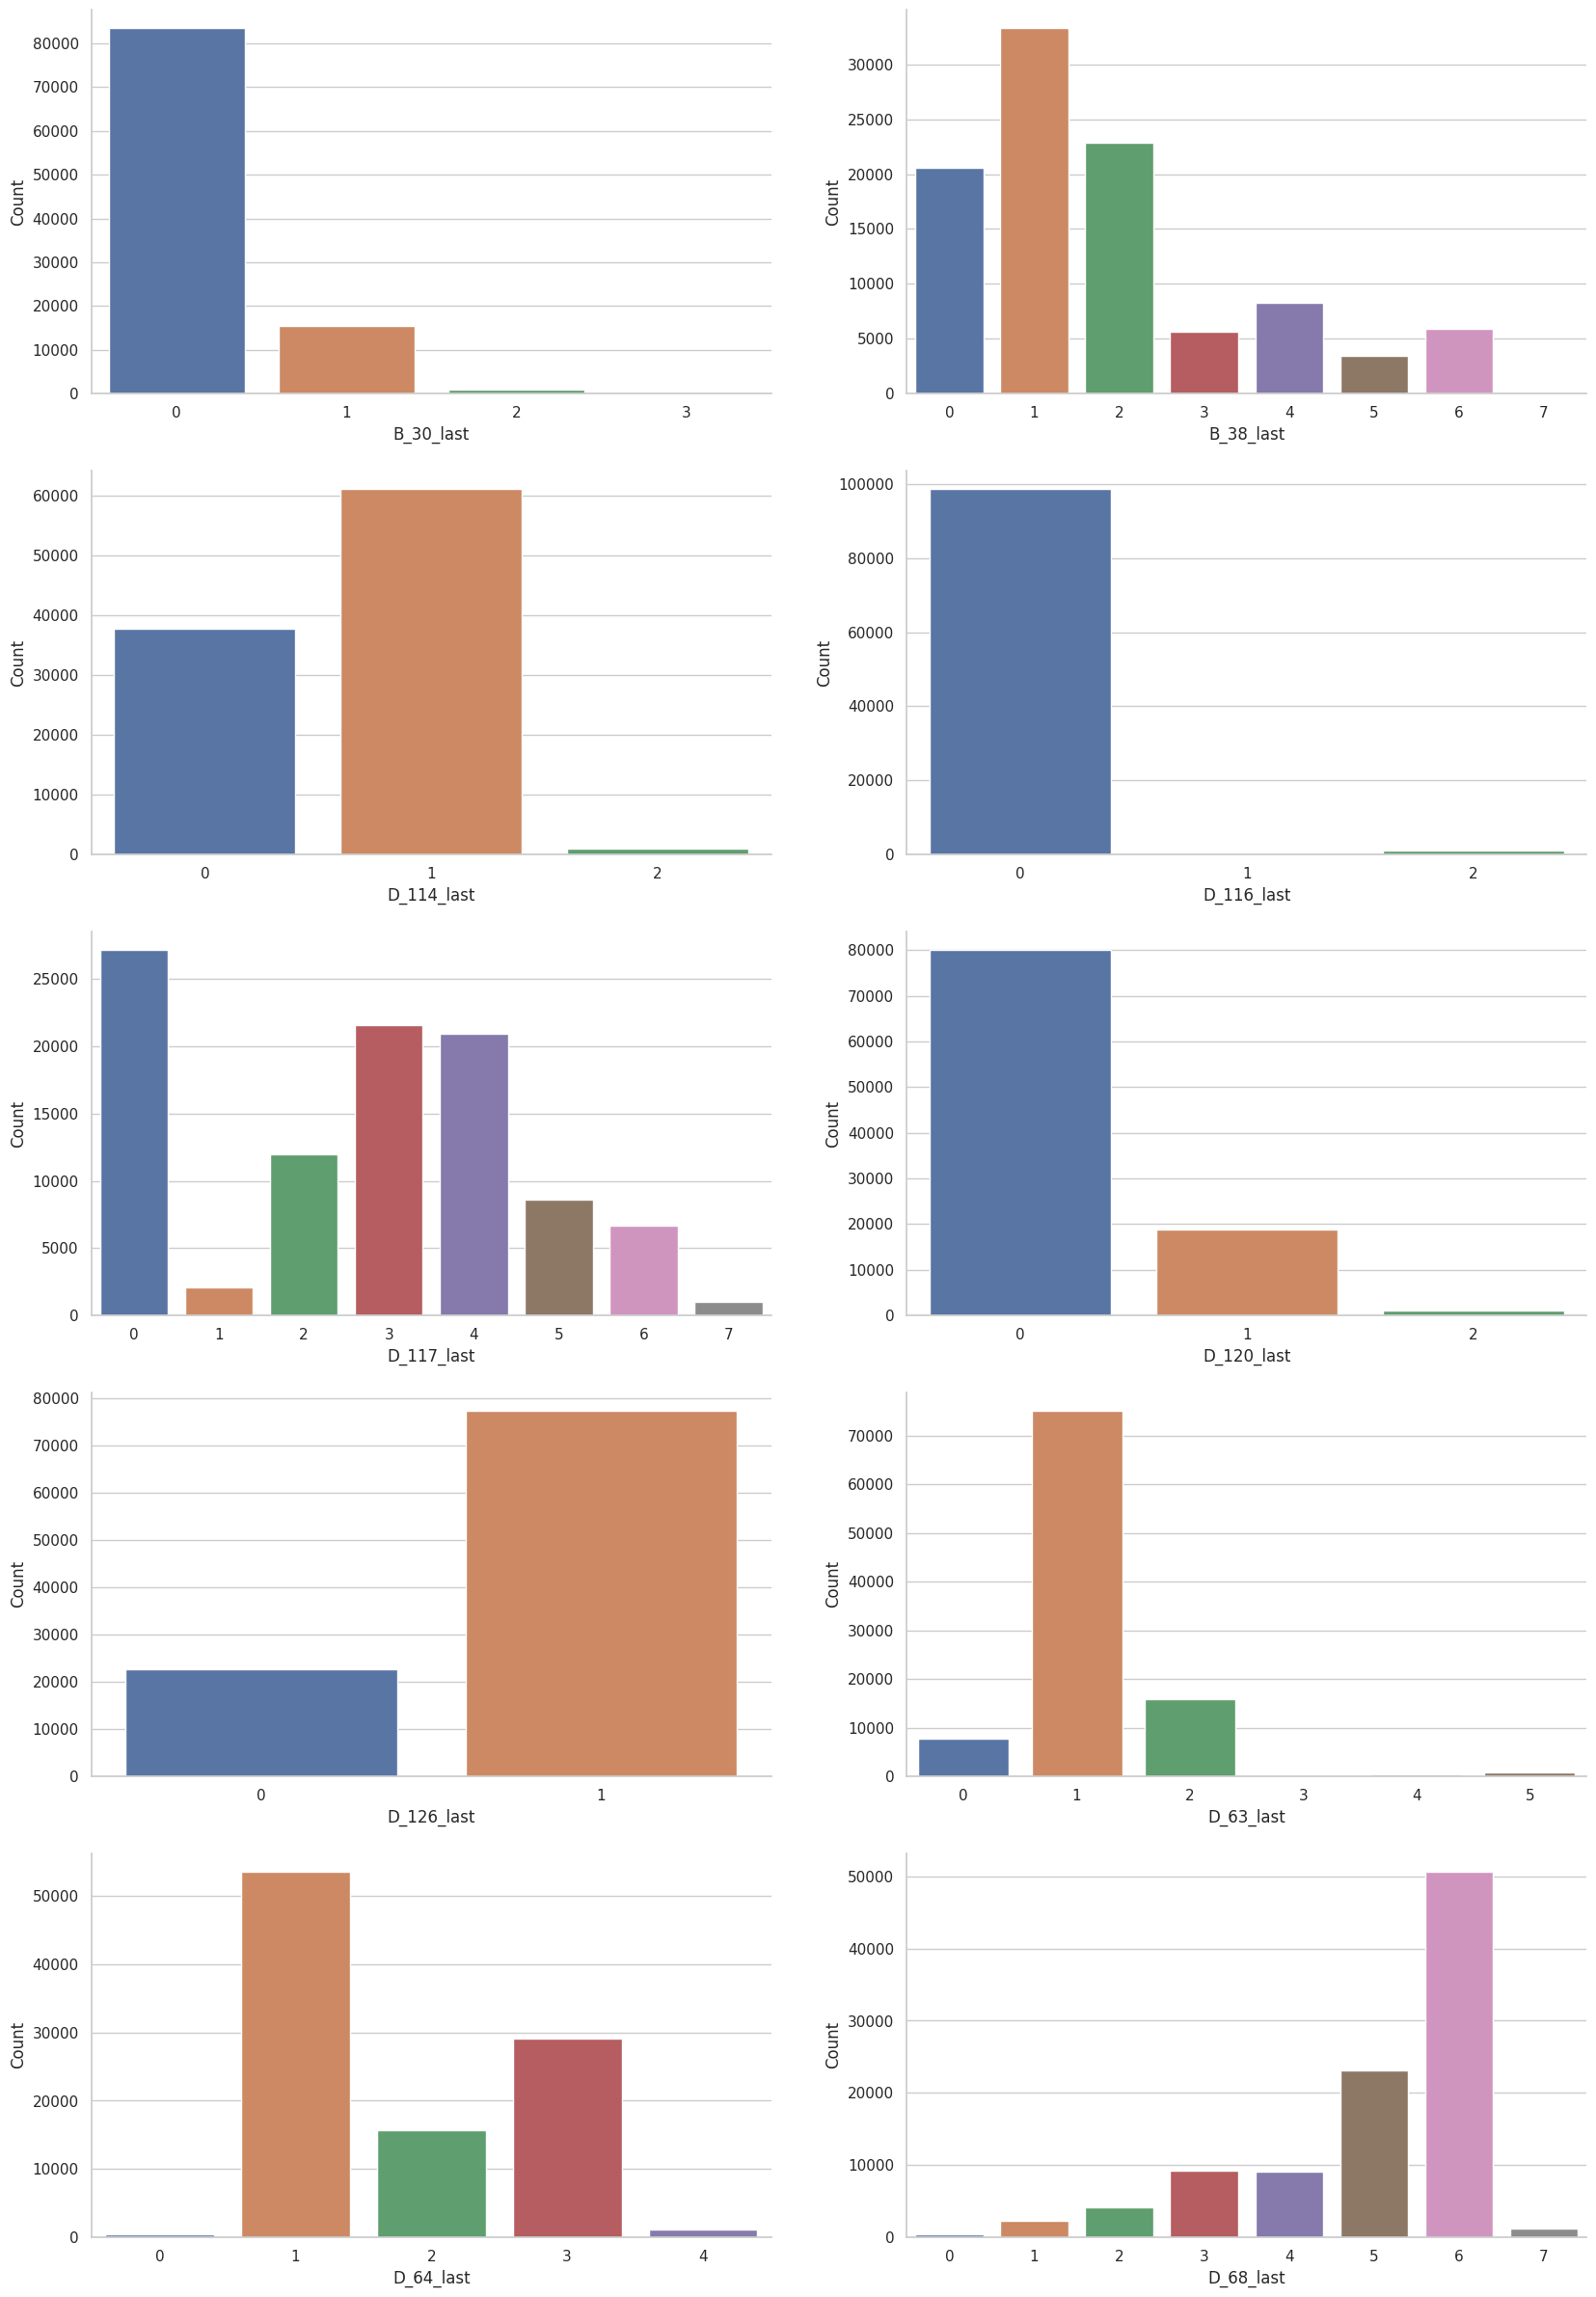

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set(style="whitegrid")
fig, axs = plt.subplots(math.ceil(len(cat_features)/2), 2, figsize=(20, 30))
for i, feature in enumerate(cat_features):
    row = i // 2
    col = i % 2
    sns.countplot(x=feature, data=df, ax=axs[row, col])
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel("Count")
    sns.despine()
plt.show()

> #### **Q. 각 피처의 target 분포를 보고싶다면 코드를 어떻게 수정해야할까요?**

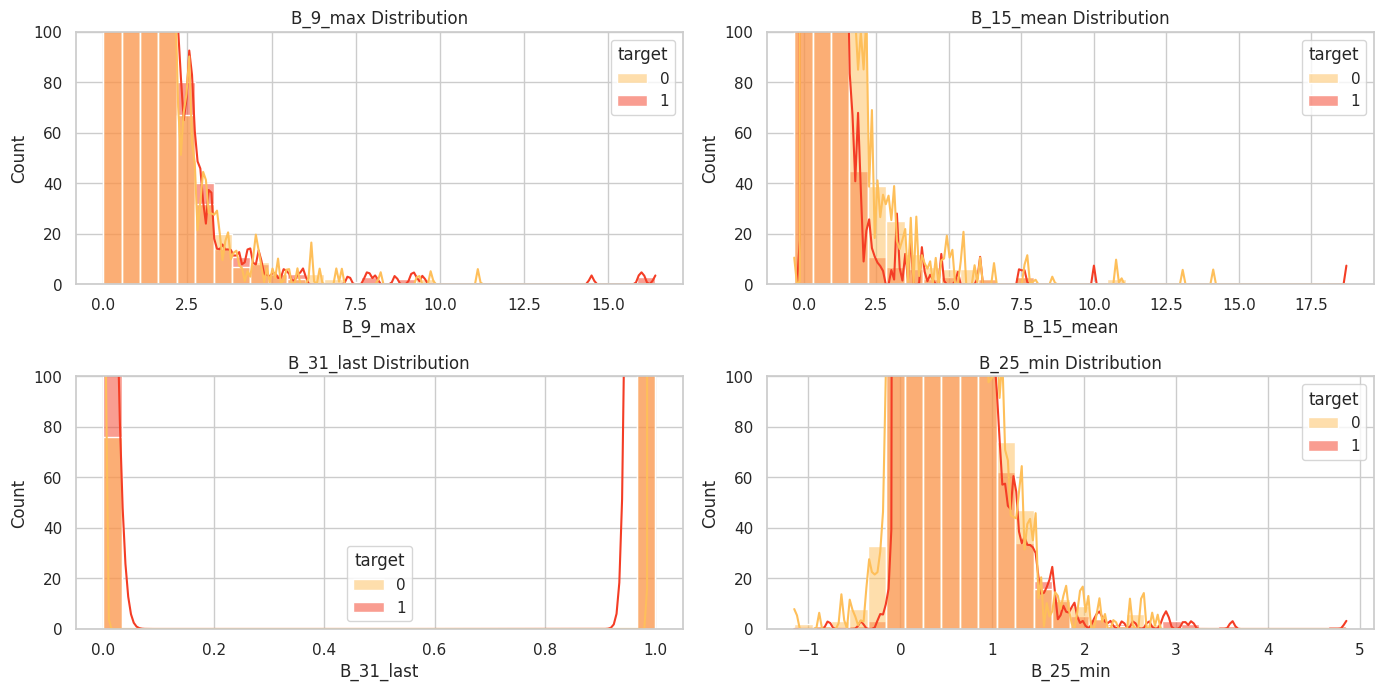

In [27]:
exp_cols = random.sample(num_cols_sample, k=4)
# num_data = train_data.select_dtypes(exclude=['object']).copy()

plt.figure(figsize=(14,10))
for idx,column in enumerate(exp_cols):
    plt.subplot(3,2,idx+1)
    sns.histplot(x=column, hue="target", data=df,bins=30,kde=True,palette='YlOrRd')
    plt.title(f"{column} Distribution")
    plt.ylim(0,100)
    plt.tight_layout()

> #### 4개의 변수만 선택해 시각화 해보았습니다. 각 변수가 타깃(0 or 1)에 따라 어떻게 분포하고 있는지 살펴볼 수 있습니다. 각 분포가 상이할 수록 예측력(predictive power)이 높을 것이라 기대할 수 있습니다. 

> #### 📊 WOE와 IV값을 계산하는 함수 구현

In [28]:
def calculate_woe_iv(df, feature_list, cat_features, target):
    result_df = pd.DataFrame(columns=['Feature', 'Bins', 'WOE', 'IV', 'IV_sum'])
    selected_features = []  # 선택된 피처들을 저장할 리스트
    bin_edges_dict = {}  # 피처별 bin 경계값을 저장할 딕셔너리
    woe_dict = {}  # 피처별 WOE 값을 저장할 딕셔너리

    for feature in feature_list:
        if feature in cat_features:  # 피처가 범주형일 경우
            df_temp = df.copy()
            df_temp[feature + '_bins'] = df_temp[feature]  # 범주형 변수의 고유값들을 bin으로 사용
            bin_edges_dict[feature] = sorted(df[feature].unique())  # 피처의 고유값들을 bin 경계값으로 저장
        else:  # 피처가 연속형일 경우
            df_temp = df.copy()
            df_temp[feature + '_bins'], bin_edges = pd.qcut(df_temp[feature], 10, duplicates='drop', retbins=True)
            bin_edges_dict[feature] = bin_edges  # 피처를 10개의 bin으로 분할하고 bin 경계값을 저장

        # 피처의 각 bin에서 이벤트와 비이벤트의 개수를 계산합니다.
        grouped_data = df_temp.groupby(feature + '_bins')[target].agg([
            ('non_event', lambda x: sum(1 - x)),  # 비이벤트(0)의 개수를 합산
            ('event', lambda x: sum(x))  # 이벤트(1)의 개수를 합산
        ]).reset_index()

        # 비이벤트와 이벤트의 비율을 계산합니다.
        grouped_data['non_event_prop'] = grouped_data['non_event'] / sum(grouped_data['non_event'])
        grouped_data['event_prop'] = grouped_data['event'] / sum(grouped_data['event'])

        # WOE(Weight of Evidence)를 계산합니다.
        grouped_data['WOE'] = np.where(
            grouped_data['event_prop'] == 0,
            0,
            np.log(grouped_data['non_event_prop'] / grouped_data['event_prop'])
        )

        # Information Value(IV)를 계산합니다.
        grouped_data['IV'] = (grouped_data['non_event_prop'] - grouped_data['event_prop']) * grouped_data['WOE']
        iv_sum = sum(grouped_data['IV'])

        if iv_sum >= 0.02:  # IV 합이 0.02 이상인 경우 피처를 선택
            selected_features.append(feature)

        result = pd.DataFrame()
        result['Feature'] = [feature] * len(grouped_data)
        result['Bins'] = grouped_data[feature + '_bins']
        result['WOE'] = grouped_data['WOE']
        result['IV'] = grouped_data['IV']
        result['IV_sum'] = [iv_sum] * len(grouped_data)

        result_df = pd.concat([result_df, result])

        woe_dict[feature] = grouped_data.set_index(feature + '_bins')['WOE'].to_dict()

    # 선택된 피처들의 개수와 목록을 출력합니다.
    print("전체 피처 개수:", len(feature_list))
    print("선택된 피처 개수:", len(selected_features))
    print("선택된 피처:", selected_features)

    return result_df, selected_features, bin_edges_dict, woe_dict



이 함수는 주어진 데이터프레임(df)와 피처 리스트(feature_list), 범주형 피처 리스트(cat_features), 그리고 타겟 변수(target)를 기반으로 Weight of Evidence(WOE)와 Information Value(IV)를 계산합니다.

설명을 상세히 드리자면:

1. 피처가 범주형일 경우, 해당 피처의 고유값들을 bin으로 사용합니다.

2. 피처가 연속형일 경우, 10개의 bin으로 분할하고 bin 경계값을 저장합니다.

3. 각 bin에서 이벤트와 비이벤트(이벤트가 발생하지 않은 경우)의 개수를 계산합니다.

4. 비이벤트와 이벤트의 비율을 계산합니다.

5. Weight of Evidence(WOE)를 계산합니다. WOE는 비이벤트 비율과 이벤트 비율의 로그 비율로 정의됩니다.

6. Information Value(IV)를 계산합니다. IV는 비이벤트 비율과 이벤트 비율의 차이에 WOE를 곱한 값입니다.

7. IV 합이 0.02 이상인 경우, 피처를 선택하고 선택된 피처 목록에 추가합니다.

8. 결과를 저장할 데이터프레임(result_df)에 계산된 WOE, IV 값을 추가합니다.

9. WOE 값을 피처별로 저장하는 딕셔너리(woe_dict)에도 계산된 값을 저장합니다.

10. 선택된 피처들의 개수와 목록을 출력합니다.

함수는 result_df(결과 데이터프레임), selected_features(선택된 피처 목록), bin_edges_dict(피처별 bin 경계값 딕셔너리), woe_dict(피처별 WOE 값 딕셔너리)를 반환합니다.






In [29]:
result_df, selected_features, bin_edges_dict, woe_dict = calculate_woe_iv(df,  feature_list, cat_features, 'target')

전체 피처 개수: 110
선택된 피처 개수: 93
선택된 피처: ['B_37_last', 'B_13_mean', 'R_7_min', 'D_52_std', 'D_45_last', 'S_23_std', 'R_17_mean', 'D_114_count', 'B_33_std', 'S_3_std', 'D_139_mean', 'R_14_last', 'B_37_max', 'D_133_last', 'R_2_last', 'D_127_max', 'B_11_mean', 'P_3_min', 'B_1_min', 'D_60_mean', 'S_26_last', 'B_25_min', 'D_83_std', 'R_8_mean', 'R_4_min', 'D_122_std', 'D_102_std', 'B_9_max', 'D_77_mean', 'D_128_max', 'D_84_mean', 'D_59_min', 'D_102_last', 'R_7_std', 'D_39_std', 'D_46_max', 'D_65_min', 'D_43_mean', 'D_122_last', 'R_20_mean', 'S_13_mean', 'B_28_last', 'D_72_std', 'B_10_max', 'B_37_mean', 'P_2_mean', 'B_11_last', 'D_78_mean', 'D_121_min', 'D_54_mean', 'B_22_last', 'R_14_max', 'P_4_std', 'S_12_std', 'B_30_nunique', 'D_70_std', 'D_107_max', 'D_53_mean', 'B_18_last', 'R_19_mean', 'B_12_last', 'S_26_min', 'R_16_max', 'D_72_max', 'D_61_min', 'R_7_mean', 'D_141_last', 'D_141_min', 'S_17_max', 'D_125_min', 'D_130_std', 'S_12_max', 'B_5_min', 'D_69_std', 'S_7_max', 'B_32_mean', 'B_37_std',

In [30]:
def transform_to_woe(df, selected_features, cat_features, bin_edges_dict, woe_dict, target):
    df_woe = df[selected_features + [target]].copy()

    for feature in selected_features:
        if feature in cat_features:
            df_woe[feature] = df_woe[feature].map(woe_dict[feature])
        else:
            feature_bins = pd.cut(df_woe[feature], bins=bin_edges_dict[feature], include_lowest=True)
            df_woe[feature] = feature_bins.map(woe_dict[feature])

    return df_woe

In [31]:
def transform_to_woe(df, selected_features, cat_features, bin_edges_dict, woe_dict, target):
    df_woe = df[selected_features + [target]].copy()

    for feature in selected_features:
        if feature in cat_features:
            # 범주형 피처의 경우, 해당 피처의 WOE 값을 매핑합니다.
            df_woe[feature] = df_woe[feature].map(woe_dict[feature])
        else:
            # 연속형 피처의 경우, bin 경계값에 따라 WOE 값을 할당합니다.
            feature_bins = pd.cut(df_woe[feature], bins=bin_edges_dict[feature], include_lowest=True)
            df_woe[feature] = feature_bins.map(woe_dict[feature])

    return df_woe


In [32]:
df_woe = transform_to_woe(df, selected_features, cat_features, bin_edges_dict, woe_dict, 'target')

In [33]:
df_woe.head()

,B_37_last,B_13_mean,R_7_min,D_52_std,D_45_last,S_23_std,R_17_mean,D_114_count,B_33_std,S_3_std,...,D_53_min,B_30_last,B_38_last,D_114_last,D_117_last,D_120_last,D_63_last,D_64_last,D_68_last,target
0,0.700144,-0.295438,-0.020098,0.201168,-0.800532,-0.257326,-1.007834,-0.665729,-0.529530,-1.348863,...,0.416116,0.469073,-1.408741,-0.508513,-0.192825,-0.956754,-0.064498,-0.489751,-0.110150,1
1,1.732439,0.850609,-0.120381,0.081349,0.929043,0.762870,0.185516,0.107246,0.302330,-0.680440,...,0.416116,0.469073,-0.394101,-0.508513,0.421929,0.291743,-0.249478,-0.489751,0.451170,0
2,-1.188347,0.116411,-0.402636,-0.188038,-0.800532,-0.257326,0.091205,-0.665729,0.198214,0.533420,...,0.416116,0.469073,1.277605,-0.371257,-0.371257,-0.371257,-0.064498,-0.359813,-0.338898,0
3,1.732439,0.386219,-0.120381,0.201168,0.929043,0.762870,0.091205,0.107246,0.158929,0.775295,...,0.416116,0.469073,1.873590,0.393672,0.751712,0.291743,-0.064498,0.474475,0.451170,0
4,-0.574498,-0.137578,0.071505,0.141142,1.076765,0.765346,0.217054,0.107246,0.212268,0.543138,...,0.416116,0.469073,1.873590,0.393672,-0.192825,0.291743,-0.249478,-0.371087,0.451170,0


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🧱 Modeling</p>

In [34]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

def xgboost_model(df_woe, target, folds=5, seed=2023):
    xgb_models = []  # XGBoost 모델들을 저장할 리스트
    xgb_oof = []  # out-of-fold 예측 결과를 저장할 리스트
    predictions = np.zeros(len(df_woe))  # 전체 데이터셋에 대한 예측 결과를 저장할 배열
    f_imp = []  # 특성 중요도를 저장할 리스트

    X = df_woe.drop(columns=[target])  # 독립 변수 데이터
    y = df_woe[target]  # 종속 변수 데이터

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f'{"#"*24} Training FOLD {fold+1} {"#"*24}')

        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
        watchlist = [(X_train, y_train), (X_valid, y_valid)]

        model = XGBClassifier(n_estimators=1000, n_jobs=-1, max_depth=4, eta=0.2, colsample_bytree=0.67)
        model.fit(X_train, y_train, eval_set=watchlist, early_stopping_rounds=300, verbose=0)

        val_preds = model.predict_proba(X_valid)[:, 1]  # 검증 세트에 대한 예측 확률
        val_score = roc_auc_score(y_valid, val_preds)  # 검증 세트의 ROC AUC 점수
        best_iter = model.best_iteration

        idx_pred_target = np.vstack([val_idx, val_preds, y_valid]).T  # 검증 세트 인덱스, 예측 확률, 실제 타겟 값으로 구성된 배열
        f_imp.append({i: j for i, j in zip(X_train.columns, model.feature_importances_)})  # 특성 중요도 저장

        print(f'{" "*20} auc:{val_score:.5f} {" "*6} best iteration:{best_iter}')

        xgb_oof.append(idx_pred_target)  # out-of-fold 예측 결과 추가
        xgb_models.append(model)  # 학습된 모델 추가

        if val_score > 0.917:
            predictions += model.predict_proba(X)[:, 1]  # 특정 조건을 만족하는 모델의 예측 확률을 누적

    predictions /= folds  # folds 수로 나눠 평균 예측 확률 계산
    mean_val_auc = np.mean([roc_auc_score(oof[:, 2], oof[:, 1]) for oof in xgb_oof])  # 평균 out-of-fold ROC AUC 점수 계산
    print('*'*45)
    print(f'Mean AUC: {mean_val_auc:.5f}')

    return xgb_models, xgb_oof, predictions, f_imp


xgb_models: XGBoost 모델들을 저장하는 리스트입니다.

xgb_oof: out-of-fold 예측 결과를 저장하는 리스트입니다. 각각의 요소는 검증 세트의 인덱스, 예측 확률, 실제 타겟 값으로 구성된 배열입니다.

predictions: 전체 데이터셋에 대한 예측 결과를 저장하는 배열입니다. 초기값은 모두 0으로 초기화됩니다.

f_imp: 특성 중요도를 저장하는 리스트입니다. 각 요소는 특성과 해당 특성의 중요도를 딕셔너리 형태로 저장합니다.

X: 독립 변수 데이터입니다.

y: 종속 변수 데이터입니다.

skf: Stratified K-Fold를 사용하여 데이터를 분할하는 객체입니다.

fold: 현재의 fold 번호입니다.

train_idx: 현재 fold에서의 학습 데이터 인덱스입니다.

val_idx: 현재 fold에서의 검증 데이터 인덱스입니다.

X_train, y_train: 현재 fold에서의 학습 데이터입니다.

X_valid, y_valid: 현재 fold에서의 검증 데이터입니다.

watchlist: XGBoost 모델의 학습을 위한 데이터셋을 지정합니다.

model: XGBoost 분류 모델입니다. 주어진 하이퍼파라미터로 초기화되고 학습됩니다.

val_preds: 검증 세트에 대한 예측 확률입니다.

val_score: 검증 세트의 ROC AUC 점수입니다.

best_iter: early stopping에 의해 선택된 최적의 반복 횟수입니다.

idx_pred_target: 검증 세트의 인덱스, 예측 확률, 실제 타겟 값으로 구성된 배열입니다.

mean_val_auc: 모든 fold의 out-of-fold 예측 결과를 평균한 ROC AUC 점수입니다.

In [35]:
df_woe.dtypes

B_37_last     category
B_13_mean     category
R_7_min       category
D_52_std      category
D_45_last     category
                ...   
D_120_last     float64
D_63_last      float64
D_64_last      float64
D_68_last      float64
target            int8
Length: 94, dtype: object

> #### XGB모델을 적합할 수 있도록 category변수를 변환해줍니다.

In [36]:
def convert_category_to_numeric(df):
    for col in df.columns:
        if str(df[col].dtype) == 'category':
            df[col] = df[col].astype('int')
    return df


In [37]:
df_woe = convert_category_to_numeric(df_woe)

In [38]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')

In [39]:
xgb_models, xgb_oof, predictions, f_imp = xgboost_model(df_woe, 'target', folds=5, seed=2023)

######################## Training FOLD 1 ########################
                     auc:0.94615        best iteration:106
######################## Training FOLD 2 ########################
                     auc:0.94778        best iteration:123
######################## Training FOLD 3 ########################
                     auc:0.94692        best iteration:147
######################## Training FOLD 4 ########################
                     auc:0.94830        best iteration:123
######################## Training FOLD 5 ########################
                     auc:0.94735        best iteration:177
*********************************************
Mean AUC: 0.94730


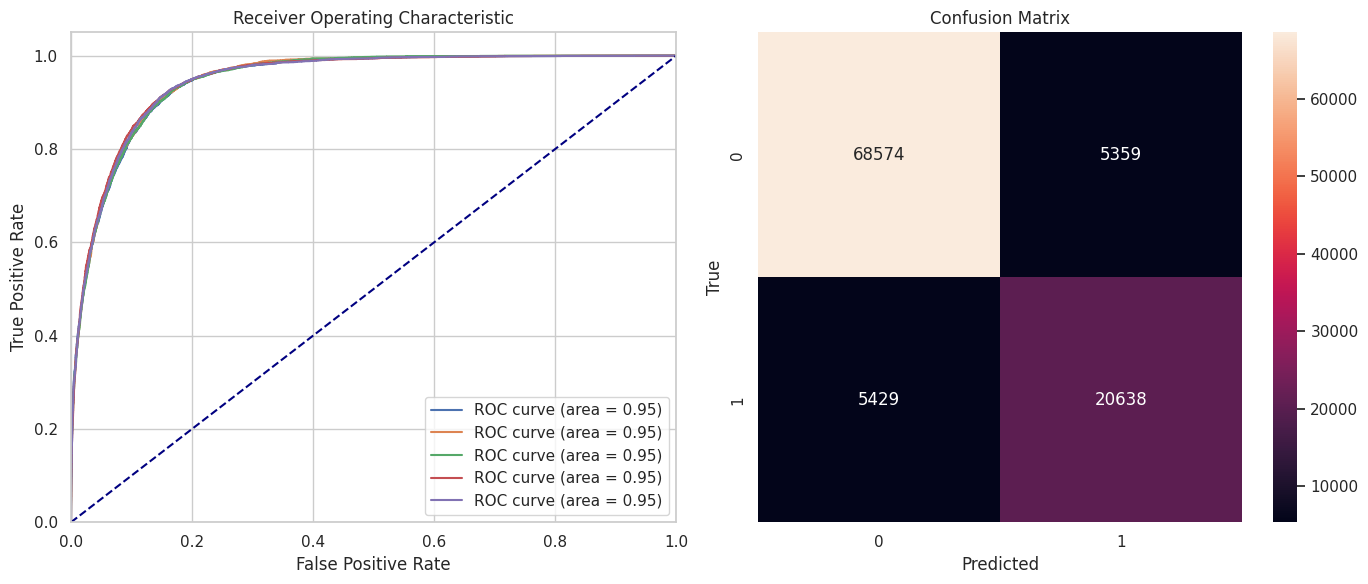

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

plt.figure(figsize=(14, 6))

# Plot ROC curves
plt.subplot(1, 2, 1)
for oof in xgb_oof:
    fpr, tpr, _ = roc_curve(oof[:, 2], oof[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Compute and plot confusion matrix
plt.subplot(1, 2, 2)
# 혼동 행렬(Confusion Matrix)을 계산하고 그립니다.
# 확률 대신 예측 클래스를 사용해야 합니다.
# 예측 임계값으로 0.5를 사용합니다.
predictions_class = [1 if pred > 0.5 else 0 for pred in predictions]
cm = confusion_matrix(df_woe['target'], predictions_class)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()



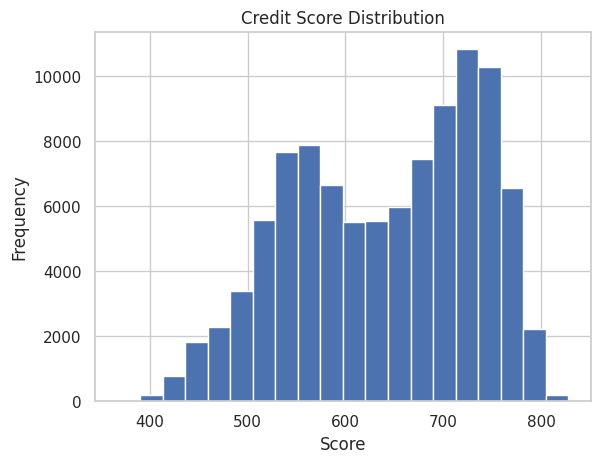

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Define the base score
base_score = 650

# Define the PDO (Point of double)
PDO = 20

# Calculate the factor and offset
factor = PDO / np.log(2)
offset = base_score - (factor * np.log(20))

# Define a function to calculate the score
def calculate_score(probability, factor, offset):
    odds = (probability / (1 - probability))
    score = offset + (factor * np.log(odds))
    return np.clip(score, 250, 1000)  # Clip scores between 250 and 1000

# Calculate the scores
scores = calculate_score(1 - predictions, factor, offset)

# Round the scores to the nearest integer
scores = np.round(scores)

# Plot the score distribution
plt.hist(scores, bins=20)
plt.title('Credit Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [42]:
# Add the predictions and scores to the dataframe
df_woe['probability'] = predictions
df_woe['credit_score'] = scores

# Select 5 random samples
samples = df_woe.sample(5, random_state=42)

# Display the samples
samples


,B_37_last,B_13_mean,R_7_min,D_52_std,D_45_last,S_23_std,R_17_mean,D_114_count,B_33_std,S_3_std,...,B_38_last,D_114_last,D_117_last,D_120_last,D_63_last,D_64_last,D_68_last,target,probability,credit_score
75721,0,0,0,0,1,0,0,0,0,-1,...,-0.394101,0.393672,-0.192825,0.291743,0.505683,-0.489751,-0.110150,0,0.152668,613.0
80184,-1,0,0,0,0,-1,0,0,0,0,...,-1.804870,0.393672,-0.128533,0.291743,-0.064498,-0.489751,-0.509633,1,0.525513,561.0
19864,2,1,0,0,0,0,0,0,0,0,...,1.277605,0.393672,-0.192825,0.291743,-0.064498,0.474475,-0.110150,0,0.004878,717.0
76699,0,0,0,0,0,0,0,0,0,0,...,1.873590,-0.508513,0.741034,0.291743,-0.064498,-0.489751,-0.110150,0,0.011634,692.0
92991,0,1,0,0,0,0,0,0,0,0,...,1.277605,-0.508513,0.421929,-0.956754,-0.064498,-0.489751,-0.714214,0,0.535189,559.0


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🧱 Inference</p>

In [43]:
def predict_and_score(model, instance, factor, offset):
    # Reshape the instance if it's a series/single row
    if len(instance.shape) == 1:
        instance = instance.values.reshape(1, -1)

    # Make prediction
    probability = model.predict_proba(instance)[:, 1]

    # Calculate score
    score = calculate_score(1 - probability, factor, offset)

    # Round the score to the nearest integer
    score = np.round(score)

    return score[0]


In [44]:
inference = df_woe.drop(['target','probability','credit_score'], axis=1)

In [45]:
inference.sample(1)

,B_37_last,B_13_mean,R_7_min,D_52_std,D_45_last,S_23_std,R_17_mean,D_114_count,B_33_std,S_3_std,...,B_20_min,D_53_min,B_30_last,B_38_last,D_114_last,D_117_last,D_120_last,D_63_last,D_64_last,D_68_last
9435,2,0,0,0,0,0,0,0,0,0,...,1,0,0.469073,1.277605,-0.508513,0.421929,0.291743,-0.064498,0.474475,0.45117


In [46]:
# Extract one sample from the data
sample = inference.sample(1)

# Call the function with the first trained model and the sample data
score = predict_and_score(xgb_models[0], sample, factor, offset)
print("해당 고객의 신용 점수는 다음과 같습니다: ", score)


해당 고객의 신용 점수는 다음과 같습니다:  730.0


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🧱 문제: KS값을 계산하고 싶다면 어떻게 해야할까? 아래 예시 코드를 참조해 만들어 보시오</p>

In [47]:
# def calculate_ks(actual, predicted):
#     pairs = zip(actual, predicted)
#     sorted_pairs = sorted(pairs, key=lambda x: x[1], reverse=True)

#     num_positive = sum(1 for actual, _ in sorted_pairs if actual == 1)
#     cum_positive_ratio = 0
#     max_ks = 0
#     max_threshold = 0

#     for i, (actual, predicted) in enumerate(sorted_pairs):
#         if actual == 1:
#             cum_positive_ratio += 1 / num_positive
#         else:
#             cum_negative_ratio = (i + 1 - cum_positive_ratio) / (len(sorted_pairs) - num_positive)

#             current_ks = abs(cum_positive_ratio - cum_negative_ratio)
#             if current_ks > max_ks:
#                 max_ks = current_ks
#                 max_threshold = predicted

#     return max_ks, max_threshold
